This Jupyter notebook details our efforts to learn the package [scVelo](https://scvelo.readthedocs.io/), a package for inferring dynamic cell lineage trajectories by computing RNA velocities from single-cell RNA-seq data. The details behind this method can be found in [Bergen et al. (2020)](https://www.nature.com/articles/s41587-020-0591-3). The tutorials can be found [here](https://scvelo.readthedocs.io/VelocityBasics.html), [here](https://scvelo.readthedocs.io/DynamicalModeling.html).

Let's start with the first tutorial, which essentially demonstrates the workflow. We first load the package and set some preliminary settings. For clarity, we should point out that as this package was written by the team behind [Scanpy](https://scanpy.readthedocs.io/en/stable/), much of the functions and structure will look similar.

In [3]:
import scvelo as scv
scv.logging.print_version()
scv.settings.verbosity = 3 #show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True # Set max width for presenter view
sc.set_figure_params('scvelo') # For 'beautified' visualisations

Running scvelo 0.2.2 (python 3.8.5) on 2020-08-20 21:09.
 Your version: 		 0.2.2 
Latest version: 	 modeling


We now load the data, which here is in-built pancreas data. In general, if we want to load our own data, we can read in the file (loom, h5ad, csv...) to an AnnData object with `adata = scv.read('path/file.loom', cache=True)`. If we want to merge our loom file into an already-existing AnnData object, we can use `scv.utils.merge(adata, adata_loom)` (I wonder if we can also directly port in data from Scanpy or Seurat, like we can do in other packages). I think in general [AnnData](https://anndata.readthedocs.io/en/latest/) is the format in which Scanpy objects come?

In [4]:
adata = scv.datasets.pancreas()
adata

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

The `adata` file stores a data matrix via `adata.X`; annotations of observations in `adata.obs`; variables in `adata.var`; and unstructured annotations in `adata.uns`. For names of observations and variables, we can access `adata.obs_names` and `adata.var_names`, respectively. The nice thing about these AnnData objects is that they can be sliced like dataframes, for example, `adata_subset = adata[:, list_of_gene_names]` (which makes sense, as in general, the data has the genes as the rows and cells by the columns).

Here, we visualise the proportions of spliced to unspliced counts for each cluster. This is important when verifying consistency in splicing efficiency at the cluster level. For this example, as is generally the case, there are variations, with slightly lower unspliced proportions at cycling ductal cells, then higher proportion at cell fate commitment Ngn3-high and pre-endocrine cells, where many genes start to be transcribed. 

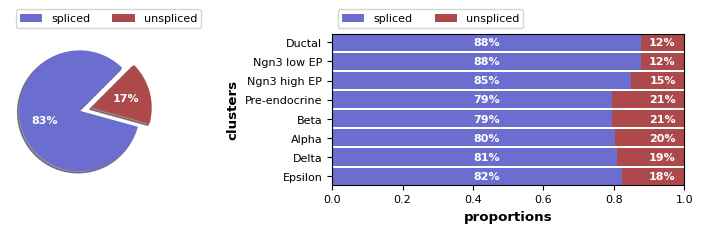

In [5]:
scv.pl.proportions(adata)

We first pre-process the data. These steps consist of gene selection via: detection (minimum number of counts) and high variability (dispersion); normalising each cell by total size; and logarithmising the data. Note that filtering and normalisation applies to both spliced/unspliced counts and the gene expresison data, while logarithmising is only applied ot gene expression data. If we've already pre-processed the data, then great! We don't need to do anything here.

In [6]:
scv.pp.filter_genes(adata, min_shared_counts=20)
scv.pp.normalize_per_cell(adata)
scv.pp.filter_genes_dispersion(adata, n_top_genes=2000)
scv.pp.log1p(adata)

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Exctracted 2000 highly variable genes.


Note that we could also just run all of this via a single function, `scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000` (pp for pre-process!).

Now we compute the first and second moments amongst nearest neighbours, which are determined by PCA space. The first moment gives us a (deterministic) velocity estimation, while the second moment gives us an estimation of stochasticity (I think this is summarised in the paper). 

In [8]:
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

computing neighbors
    finished (0:00:05) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


Note that we may also want to do things like batch effect correction etc.

We're now in a position to estimate RNA velocity! These velocities are obtained by modelling the transcriptional dynamics of mRNA splicing kinetics. We can choose to implement a stochastic model, which is the default, or a deterministic model, by setting `mode='deterministic'`. For each gene, we fit the steady-state ratio of pre-mature (unspliced) to mature (spliced) mRNA counts, which constitutes a constant transcriptional state. Velocities are then obtained as the residuals from this ratio. A positive velocity will indicate up-regulation of a gene, whilc a negative velocity indicates down-regulation. The former occurs for cells that exhibit a higher abundance of unsplied mRNA for that gene than would be expected in steady state.

The full dynamical model is then solved by setting `mode='dynamical'`, which runs `scv.tl.recover_dynamics(adata)`. The second tutorial will talk more about this, but for now, let's just run the following one-line code:

In [11]:
scv.tl.velocity(adata) # Calculate the RNA velocities

computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


Computed velocities are stored in the object `adata.layers`, just like the count matrices.

The combination of velocities across genes can then be used to estimate the future state of an individual cell. In order to project the velocities, transition probabilities are estimated. That is, we estimate the likely cell transitions in accordance with the directions implied by the RNA velocities. Transition probabilities are calculated by using the cosine correlation between potential cell-to-cell transitions and the velocity vector, which are then stored in a matrix that's called the velocity graph. The graph is essentially an adjacency matrix of size $n_{obs} \times n_{obs}$. If we need to, we can speed up this computation time by computing the velocities on reduced PCA space instead, by setting `approx=True`'.

In [12]:
scv.tl.velocity_graph(adata) # Compute the velocity graph so that we can project the velocities onto the UMAP

computing velocity graph
    finished (0:00:11) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


Very interestingly, we can actually convert the velocity graph into a (Markov) transitional probability atrix by applying a Gaussian kernel to transform the cosine correlations (i.e. the centred correlations) into transition probabilities via `scv.utils.get_transition_matrix`. 

**Big question**: is there any reason to believe this process should be Markovian? Recent talks suggest perhaps not!

Regardless, the transition matrix is used to project hte velocities into a low-dimensional embedding (tSNE or UMAP, I guess) by applying the mean transition, via `scv.tl.velocity_embedding`. By using this transition matrix, we can further calculate terminal states of the Markov chain, which is equivalent to tracing the cell trajectories to their origins and potential fates.

After calculating the velocities, we can project them onto any embedding, i.e. the `basis` of choice (tSNE or UMAP). We have three default choices for visualisation: at the cellular level with `scv.pl.velocity_embedding`; as gridlines with `scv.pl.velocity_embedding_grid`; or as streamlines with `scv.pl.velocity_embedding_stream`.

We make a point here that this dataset already has a UMAP embedding and clusteirng attached. If we wanted to run these on our own data, we can do this via `scv.tl.umap` and `scv.tl.louvain`, or via Seurat/Scanpy, I imagine. It should be said that the default parameters for all plotting methods are `basis='umap'` and `color='clusters'`.

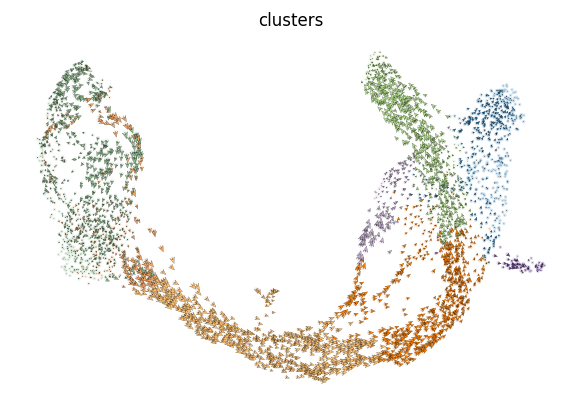

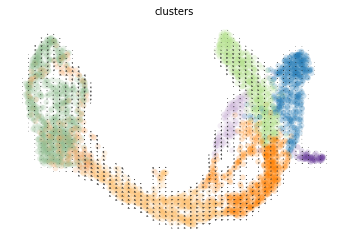

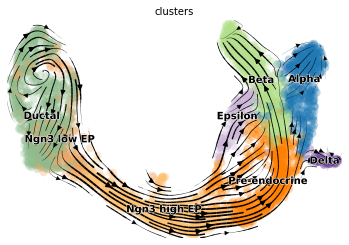

In [14]:
scv.pl.velocity_embedding(adata, basis='umap', arrow_length=3, arrow_size=2, dpi=120) # Plot at cell level
scv.pl.velocity_embedding_grid(adata) # Plot as gridlines
scv.pl.velocity_embedding_stream(adata) # Plot as streamlines

If I'm honest, the streamlines look the best, but I concede it can be harder to see the direct cell clusters.